# Librerías a utilizar

In [21]:
from base64 import b32encode
from dotenv import load_dotenv
from funciones_auxiliares import obtener_access_token_para_la_api_de_spotify
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests

# Análisis exploratorio de los datos

Inicialmente, los datasets se ven como sigue:

In [22]:
track_features = pd.read_csv('data/tf_mini.csv')
print('Dataset Track Features:')
print('- Filas:', track_features.shape[0])
print('- Columnas:', track_features.shape[1])
print('- Datos nulos:', track_features.isna().sum().sum())

Dataset Track Features:
- Filas: 50704
- Columnas: 30
- Datos nulos: 0


In [23]:
sessions = pd.read_csv('data/log_mini.csv')
print('Dataset Sessions:')
print('- Filas:', sessions.shape[0])
print('- Columnas:', sessions.shape[1])
print('- Datos nulos:', sessions.isna().sum().sum())


Dataset Sessions:
- Filas: 167880
- Columnas: 21
- Datos nulos: 0


Conservaremos solamente las columnas que puedan ser obtenidas de la API de Spotify:

In [24]:
track_features = track_features.drop(columns=['beat_strength', 'bounciness', 'dyn_range_mean', 'flatness', 'mechanism', 'organism'])
print('Dataset Track Features, sin columnas no obtenibles de la API de Spotify:')
print('- Filas:', track_features.shape[0])
print('- Columnas:', track_features.shape[1])
print('- Datos nulos:', track_features.isna().sum().sum())

Dataset Track Features, sin columnas no obtenibles de la API de Spotify:
- Filas: 50704
- Columnas: 24
- Datos nulos: 0


Número de reproducciones por sesión:

(array([ 819.,  752.,  646.,  547.,  459.,  435.,  339.,  320.,  303.,
        5380.]),
 array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 10 artists>)

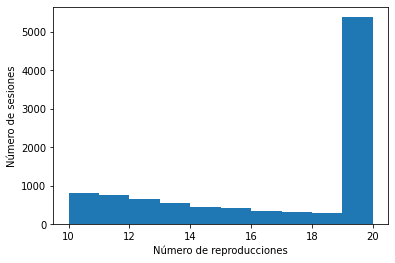

In [32]:
sessions.loc[:, 'cuenta'] = 1
plt.xlabel('Número de reproducciones')
plt.ylabel('Número de sesiones')
plt.hist(x=sessions.groupby('session_id').count()['cuenta'])